In [1]:
# load general python utilities
import math
import datetime
import string

from dateutil.relativedelta import *

# load modules for working with data
import pandas as pd
import numpy as np

# load modules for visualizations
import seaborn as sns
import matplotlib.pyplot as plt

# load modules for standardization, modelling and evaluations
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# load modules for statistical computations
from patsy import dmatrices

from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.formula.api as sm

In [2]:
# method in this cell was created by Or Herman-Saffar (Data Scientist @ Dell), and code has been taken from https://towardsdatascience.com/time-based-cross-validation-d259b13d42b8

# define function for time-based train test splitting for cross-validation
class TimeBasedCV(object):
    """
    Parameters
    ----------
    train_period: int
        number of time units to include in each train set
        default is 30
    test_period: int
        number of time units to include in each test set
        default is 7
    freq: string
        frequency of input parameters. possible values are: days, months, years, weeks, hours, minutes, seconds
        possible values designed to be used by dateutil.relativedelta class
        deafault is days
    """

    def __init__(self, train_period=30, test_period=7, freq="days"):
        self.train_period = train_period
        self.test_period = test_period
        self.freq = freq

    def split(self, data, validation_split_date=None, date_column="record_date", gap=0):
        """
        Generate indices to split data into training and test set

        Parameters
        ----------
        data: pandas DataFrame
            your data, contain one column for the record date
        validation_split_date: datetime.date()
            first date to perform the splitting on.
            if not provided will set to be the minimum date in the data after the first training set
        date_column: string, deafult='record_date'
            date of each record
        gap: int, default=0
            for cases the test set does not come right after the train set,
            *gap* days are left between train and test sets

        Returns
        -------
        train_index ,test_index:
            list of tuples (train index, test index) similar to sklearn model selection
        """

        # check that date_column exist in data:
        try:
            data[date_column]
        except:
            raise KeyError(date_column)

        train_indices_list = []
        test_indices_list = []

        if validation_split_date == None:
            validation_split_date = data[date_column].min().date() + eval(
                "relativedelta(" + self.freq + "=self.train_period)"
            )

        start_train = validation_split_date - eval(
            "relativedelta(" + self.freq + "=self.train_period)"
        )
        end_train = start_train + eval(
            "relativedelta(" + self.freq + "=self.train_period)"
        )
        start_test = end_train + eval("relativedelta(" + self.freq + "=gap)")
        end_test = start_test + eval(
            "relativedelta(" + self.freq + "=self.test_period)"
        )

        while end_test < data[date_column].max().date():
            # train indices:
            cur_train_indices = list(
                data[
                    (data[date_column].dt.date >= start_train)
                    & (data[date_column].dt.date < end_train)
                ].index
            )

            # test indices:
            cur_test_indices = list(
                data[
                    (data[date_column].dt.date >= start_test)
                    & (data[date_column].dt.date < end_test)
                ].index
            )

            print(
                "Train period:",
                start_train,
                "-",
                end_train,
                ", Test period",
                start_test,
                "-",
                end_test,
                "# train records",
                len(cur_train_indices),
                ", # test records",
                len(cur_test_indices),
            )

            train_indices_list.append(cur_train_indices)
            test_indices_list.append(cur_test_indices)

            # update dates:
            start_train = start_train + eval(
                "relativedelta(" + self.freq + "=self.test_period)"
            )
            end_train = start_train + eval(
                "relativedelta(" + self.freq + "=self.train_period)"
            )
            start_test = end_train + eval("relativedelta(" + self.freq + "=gap)")
            end_test = start_test + eval(
                "relativedelta(" + self.freq + "=self.test_period)"
            )

        # mimic sklearn output
        index_output = [
            (train, test) for train, test in zip(train_indices_list, test_indices_list)
        ]

        self.n_splits = len(index_output)

        return index_output

    def get_n_splits(self):
        """Returns the number of splitting iterations in the cross-validator
        Returns
        -------
        n_splits : int
            Returns the number of splitting iterations in the cross-validator.
        """
        return self.n_splits

In [3]:
# load media spends and sales volume data and save into data frame
media_spends_sales = pd.read_csv(
    "Sample Media Spend Data.csv", parse_dates=["Calendar_Week"]
)

In [4]:
# check for columns with missing data
media_spends_sales.isnull().any()

Division                 False
Calendar_Week            False
Paid_Views               False
Organic_Views            False
Google_Impressions       False
Email_Impressions        False
Facebook_Impressions     False
Affiliate_Impressions    False
Overall_Views            False
Sales                    False
dtype: bool

In [5]:
# check data types of available columns
media_spends_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3051 entries, 0 to 3050
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Division               3051 non-null   object        
 1   Calendar_Week          3051 non-null   datetime64[ns]
 2   Paid_Views             3051 non-null   int64         
 3   Organic_Views          3051 non-null   int64         
 4   Google_Impressions     3051 non-null   int64         
 5   Email_Impressions      3051 non-null   float64       
 6   Facebook_Impressions   3051 non-null   int64         
 7   Affiliate_Impressions  3051 non-null   int64         
 8   Overall_Views          3051 non-null   int64         
 9   Sales                  3051 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(7), object(1)
memory usage: 238.5+ KB


In [6]:
# glimpse data values
media_spends_sales.head()

,Division,Calendar_Week,Paid_Views,Organic_Views,Google_Impressions,Email_Impressions,Facebook_Impressions,Affiliate_Impressions,Overall_Views,Sales
0,A,2018-01-06,392,422,408,349895.0107,73580,12072,682,59417
1,A,2018-01-13,787,904,110,506270.2176,11804,9499,853,56806
2,A,2018-01-20,81,970,742,430042.1538,52232,17048,759,48715
3,A,2018-01-27,25,575,65,417745.6658,78640,10207,942,72047
4,A,2018-02-03,565,284,295,408505.8012,40561,5834,658,56235


In [7]:
# check for number of data points for each division to understand data hierarchy
print(len(media_spends_sales.Division.unique()), "Divisions")

media_spends_sales.Division.value_counts()

26 Divisions


Z    226
U    113
V    113
G    113
R    113
I    113
F    113
O    113
C    113
T    113
N    113
J    113
P    113
S    113
Q    113
M    113
H    113
B    113
X    113
Y    113
E    113
L    113
D    113
A    113
W    113
K    113
Name: Division, dtype: int64

In [8]:
# rectify wrongly encrypted data (last 113 weeks data should belong to different division)
media_spends_sales.iloc[len(media_spends_sales) - 113 :, 0] = "AA"

In [9]:
# scale data to unit variance and zero mean
media_spends_sales_scaled = media_spends_sales.copy()

sc = StandardScaler()

media_spends_sales_scaled.loc[:, "Paid_Views":"Sales"] = sc.fit_transform(
    media_spends_sales_scaled.loc[:, "Paid_Views":"Sales"]
)

<AxesSubplot:>

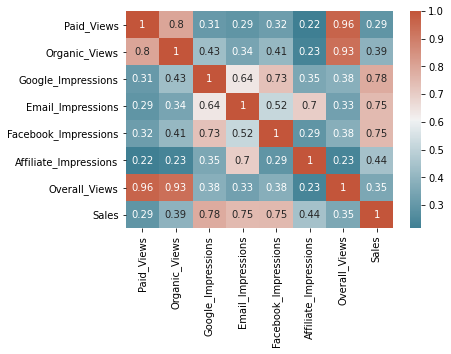

In [10]:
# check for high correlations in data
corr = media_spends_sales_scaled.corr()

sns.heatmap(
    corr,
    xticklabels=corr.columns,
    yticklabels=corr.columns,
    annot=True,
    cmap=sns.diverging_palette(220, 20, as_cmap=True),
)

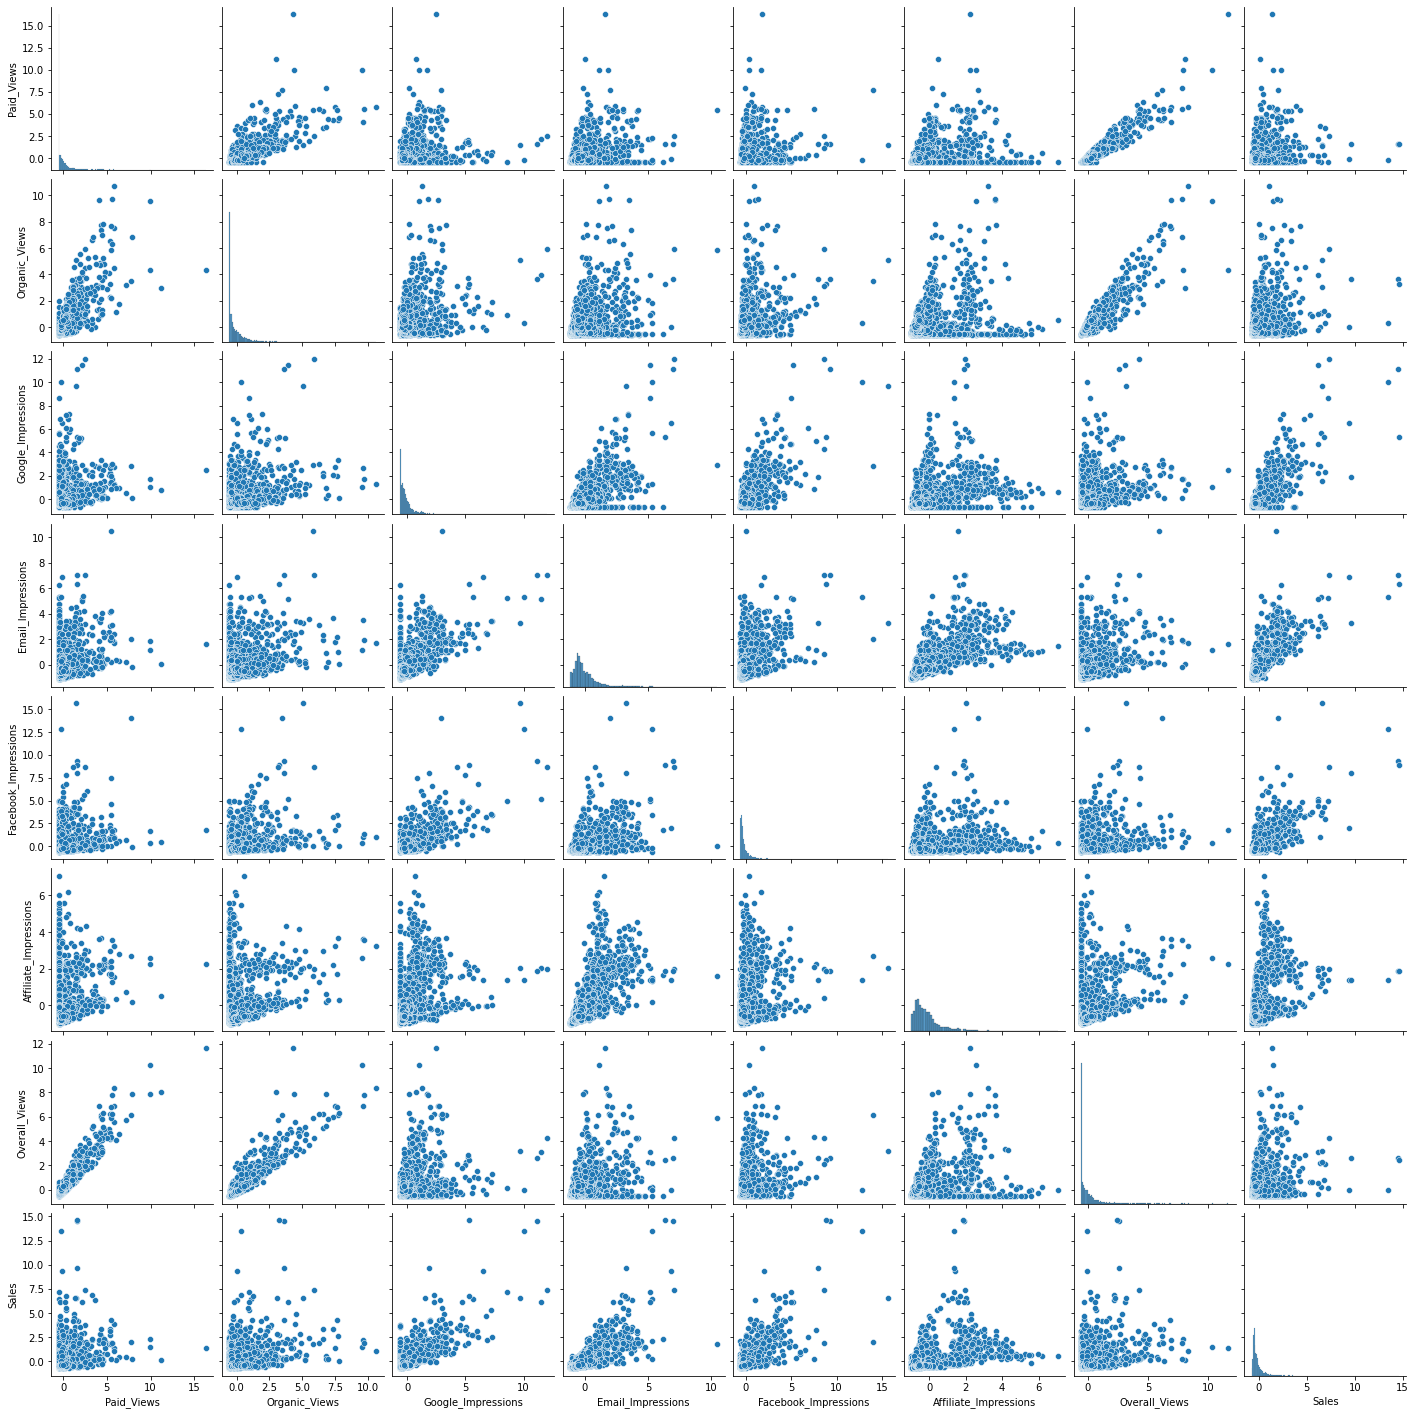

In [11]:
# check for linear relationships between predictors and response
sns.pairplot(media_spends_sales_scaled)

In [12]:
# dummy code 'Division' column
media_spends_sales_coded = pd.get_dummies(media_spends_sales_scaled)

In [33]:
media_spends_sales_coded.columns

Index(['Calendar_Week', 'Paid_Views', 'Organic_Views', 'Google_Impressions',
       'Email_Impressions', 'Facebook_Impressions', 'Affiliate_Impressions',
       'Overall_Views', 'Sales', 'Division_A', 'Division_AA', 'Division_B',
       'Division_C', 'Division_D', 'Division_E', 'Division_F', 'Division_G',
       'Division_H', 'Division_I', 'Division_J', 'Division_K', 'Division_L',
       'Division_M', 'Division_N', 'Division_O', 'Division_P', 'Division_Q',
       'Division_R', 'Division_S', 'Division_T', 'Division_U', 'Division_V',
       'Division_W', 'Division_X', 'Division_Y', 'Division_Z'],
      dtype='object')

In [13]:
# sort data chronologically and ignore original indexes
media_spends_sales_coded.sort_values(by="Calendar_Week", inplace=True)

media_spends_sales_coded.reset_index(drop=True, inplace=True)

<AxesSubplot:xlabel='Feature', ylabel='Gini Importance Score (Normalised)'>

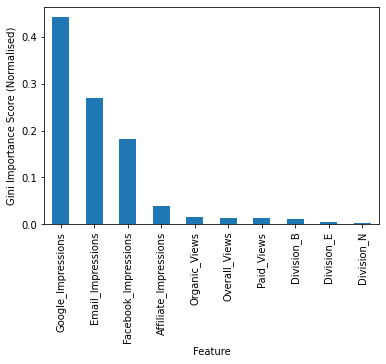

In [14]:
# find important variables using random forest regression
X = media_spends_sales_coded.loc[
    :,
    (media_spends_sales_coded.columns != "Sales")
    & (media_spends_sales_coded.columns != "Calendar_Week"),
]

y = media_spends_sales_coded["Sales"]

rf_model = RandomForestRegressor(random_state=50)

rf_model.fit(X, y)

feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns)

# display top 10 variables with highest importance
feature_importances.nlargest(10).plot(
    kind="bar",
    figsize=(6, 4),
    xlabel="Feature",
    ylabel="Gini Importance Score (Normalised)",
)

In [15]:
# save top 10 features with highest importance
important_features = feature_importances[feature_importances >= 0.002].index.to_list()

In [16]:
# display top 10 features
important_features

['Paid_Views',
 'Organic_Views',
 'Google_Impressions',
 'Email_Impressions',
 'Facebook_Impressions',
 'Affiliate_Impressions',
 'Overall_Views',
 'Division_B',
 'Division_E',
 'Division_N']

In [17]:
# check for multicollinearity problem between model predictors
features = "+".join(important_features)

y, X = dmatrices(
    "Sales ~" + features, media_spends_sales_coded, return_type="dataframe"
)

vif = pd.DataFrame()

vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

vif["features"] = X.columns

vif.round(1)

,VIF Factor,features
0,1.3,Intercept
1,3833.6,Paid_Views
2,2349.6,Organic_Views
3,3.0,Google_Impressions
4,3.7,Email_Impressions
5,2.3,Facebook_Impressions
6,3.4,Affiliate_Impressions
7,10966.0,Overall_Views
8,2.2,Division_B
9,2.0,Division_E


In [18]:
# remove predictors causing multicollinearity ('Paid_Views' & 'Overall_Views') and negative coefficients ('Organic_Views' & 'Affiliate_Impressions') in linear model
# predictors causing negative coefficients are found later
index = [0, 1, 5, 6]

important_features = np.delete(important_features, index).tolist()

In [19]:
# check if problem is cured after removing variables from model
features = "+".join(important_features)

y, X = dmatrices(
    "Sales ~" + features, media_spends_sales_coded, return_type="dataframe"
)

vif = pd.DataFrame()

vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

vif["features"] = X.columns

vif.round(1)

,VIF Factor,features
0,1.2,Intercept
1,2.8,Google_Impressions
2,2.6,Email_Impressions
3,2.2,Facebook_Impressions
4,1.9,Division_B
5,1.1,Division_E
6,1.1,Division_N


In [20]:
# perform initial time-based train-test split: 90/10
split_index = math.floor(0.9 * 113) * 27

# define time-based train-validation set sizes for cross-validation within train set
tscv = TimeBasedCV(train_period=29, test_period=7, freq="weeks")

# play around with intitial validation set split date to see number of cross-validation (CV) iterations
for train_index, test_index in tscv.split(
    media_spends_sales_coded.iloc[
        :split_index,
    ],
    validation_split_date=datetime.date(2018, 7, 28),
    date_column="Calendar_Week",
):
    print(train_index, test_index)

# add 'Calendar_Week' to features vector for use in splitting
important_features.append("Calendar_Week")

# perform initial train-test split (use important features only)
X = media_spends_sales_coded.loc[
    :, media_spends_sales_coded.columns.isin(important_features)
]

y = media_spends_sales_coded["Sales"]

X_train = X.iloc[
    :split_index,
]

X_test = X.iloc[
    split_index:,
]

y_train = y.iloc[:split_index]

y_test = y.iloc[split_index:]

Train period: 2018-01-06 - 2018-07-28 , Test period 2018-07-28 - 2018-09-15 # train records 783 , # test records 189
Train period: 2018-02-24 - 2018-09-15 , Test period 2018-09-15 - 2018-11-03 # train records 783 , # test records 189
Train period: 2018-04-14 - 2018-11-03 , Test period 2018-11-03 - 2018-12-22 # train records 783 , # test records 189
Train period: 2018-06-02 - 2018-12-22 , Test period 2018-12-22 - 2019-02-09 # train records 783 , # test records 189
Train period: 2018-07-21 - 2019-02-09 , Test period 2019-02-09 - 2019-03-30 # train records 783 , # test records 189
Train period: 2018-09-08 - 2019-03-30 , Test period 2019-03-30 - 2019-05-18 # train records 783 , # test records 189
Train period: 2018-10-27 - 2019-05-18 , Test period 2019-05-18 - 2019-07-06 # train records 783 , # test records 189
Train period: 2018-12-15 - 2019-07-06 , Test period 2019-07-06 - 2019-08-24 # train records 783 , # test records 189
Train period: 2019-02-02 - 2019-08-24 , Test period 2019-08-24 -

In [21]:
# perform cross-validation on train data to check performance of linear model on unseen data
X = X_train

y = y_train

r2_scores_train = []

r2_scores_test = []

mse_scores_train = []

mse_scores_test = []

for train_index, test_index in tscv.split(
    X, validation_split_date=datetime.date(2018, 7, 28), date_column="Calendar_Week"
):

    # define train and validation for this CV iteration
    data_train = X.loc[train_index].drop("Calendar_Week", axis=1)

    target_train = y.loc[train_index]

    data_test = X.loc[test_index].drop("Calendar_Week", axis=1)

    target_test = y.loc[test_index]

    # fit optimal least squares (OLS) linear regression model
    ols_model = linear_model.LinearRegression()

    ols_model.fit(data_train, target_train)

    # perfrom prediction on train
    ols_preds_train = ols_model.predict(data_train)

    # record train scores and errors
    r2_scores_train.append(r2_score(target_train, ols_preds_train))

    mse_scores_train.append(mean_squared_error(target_train, ols_preds_train))

    # perfrom prediction on test
    ols_preds_test = ols_model.predict(data_test)

    # record test scores and errors
    r2_scores_test.append(r2_score(target_test, ols_preds_test))

    mse_scores_test.append(mean_squared_error(target_test, ols_preds_test))

# display train and test scores for comparison and model evaluation
print("OLS Model:")

print("R-Squared Score (Train): ", np.mean(r2_scores_train))

print("R-Squared Score (Test): ", np.mean(r2_scores_test))

print("Mean Squared Error (Train): ", np.mean(mse_scores_train))

print("Mean Squared Error (Test): ", np.mean(mse_scores_test))

Train period: 2018-01-06 - 2018-07-28 , Test period 2018-07-28 - 2018-09-15 # train records 783 , # test records 189
Train period: 2018-02-24 - 2018-09-15 , Test period 2018-09-15 - 2018-11-03 # train records 783 , # test records 189
Train period: 2018-04-14 - 2018-11-03 , Test period 2018-11-03 - 2018-12-22 # train records 783 , # test records 189
Train period: 2018-06-02 - 2018-12-22 , Test period 2018-12-22 - 2019-02-09 # train records 783 , # test records 189
Train period: 2018-07-21 - 2019-02-09 , Test period 2019-02-09 - 2019-03-30 # train records 783 , # test records 189
Train period: 2018-09-08 - 2019-03-30 , Test period 2019-03-30 - 2019-05-18 # train records 783 , # test records 189
Train period: 2018-10-27 - 2019-05-18 , Test period 2019-05-18 - 2019-07-06 # train records 783 , # test records 189
Train period: 2018-12-15 - 2019-07-06 , Test period 2019-07-06 - 2019-08-24 # train records 783 , # test records 189
Train period: 2019-02-02 - 2019-08-24 , Test period 2019-08-24 -

In [22]:
# after CV, use whole train set together for training model
lin_reg_mod = linear_model.LinearRegression()

In [23]:
# fit
lin_reg_mod.fit(X_train.drop("Calendar_Week", axis=1), y_train)

LinearRegression()

In [24]:
# predict on train (just for comparison)
ols_preds_train = lin_reg_mod.predict(X_train.drop("Calendar_Week", axis=1))

# predict on test
ols_preds_test = lin_reg_mod.predict(X_test.drop("Calendar_Week", axis=1))

# display evaluation scores for train and test together to check for overfitting
print("OLS Model: ")

print("Mean Absolute Error (Train): ", mean_absolute_error(y_train, ols_preds_train))

print("Mean Absolute Error (Test): ", mean_absolute_error(y_test, ols_preds_test))

print("")

print("Mean Squared Error (Train): ", mean_squared_error(y_train, ols_preds_train))

print("Mean Squared Error (Test): ", mean_squared_error(y_test, ols_preds_test))

print("")

print("R-Squared Score (Train): ", r2_score(y_train, ols_preds_train))

print("R-Squared Score (Test): ", r2_score(y_test, ols_preds_test))

print("")

print("")

print("Simple Model:")

print(
    "Mean Squared Error (Test): ",
    mean_squared_error(np.repeat(np.mean(y_test), len(y_test)), y_test),
)

OLS Model: 
Mean Absolute Error (Train):  0.22343875678278902
Mean Absolute Error (Test):  0.3576746236450276

Mean Squared Error (Train):  0.19533233834549033
Mean Squared Error (Test):  0.43651577930897323

R-Squared Score (Train):  0.8013752715684136
R-Squared Score (Test):  0.6083136100814721


Simple Model:
Mean Squared Error (Test):  1.1144522519655837


In [25]:
# display intercept and predictor coefficients
print("Intercept: ", lin_reg_mod.intercept_)

coefficient_vector = list(lin_reg_mod.coef_)[0:3]

print("Coefficients: ", lin_reg_mod.coef_)

Intercept:  -0.06291002926313148
Coefficients:  [0.37561213 0.33592656 0.21115683 0.48186971 0.30399495 0.46690654]


In [26]:
# get same output but shiny with some more stats using different function with same functionality
model = sm.ols(
    formula="Sales ~ Google_Impressions + Email_Impressions + Facebook_Impressions + Division_B + Division_E+ Division_N",
    data=pd.concat([X_train.drop("Calendar_Week", axis=1), y_train], axis=1),
).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.801
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     1829.
Date:                Mon, 07 Jun 2021   Prob (F-statistic):               0.00
Time:                        20:09:19   Log-Likelihood:                -1642.8
No. Observations:                2727   AIC:                             3300.
Df Residuals:                    2720   BIC:                             3341.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.0629      0.009     -6.692      0.000      -0.081      -0.044
Google_Impressions       0.3756      0.014     26.552      0.000       0.348       0.403
Email_Impressions        0.3359      0.015     23.111      0.000       0.307       0.364
Facebook_Impressions     0.2112      0.013     16.197      0.000       0.186       0.237
Division_B               0.4819      0.064      7.573      0.000       0.357       0.607
Division_E               0.3040      0.048      6.295      0.000       0.209       0.399
Division_N               0.4669      0.047     10.021      0.000       0.376       0.558
==============================================================================
Omnibus:                     2871.436   Durbin-Watson:                   1.177
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           557697.365
Skew:                           4.781   Prob(JB):                         0.00
Kurtosis:                      72.403   Cond. No.                         12.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

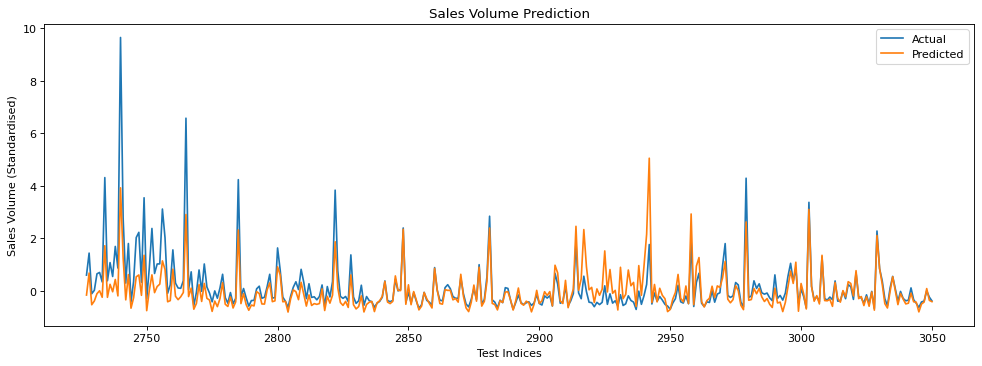

In [27]:
# show test set predictions compared to actual sales volume
prediction_results = pd.DataFrame(
    {
        "Actual": y_test,
        "Predicted": ols_preds_test,
    }
)

fig = plt.figure(figsize=(15, 5), dpi=80)

ax = fig.add_subplot(1, 1, 1)

prediction_results.plot(
    y=["Actual", "Predicted"],
    ax=ax,
    title="Sales Volume Prediction",
    ylabel="Sales Volume (Standardised)",
    xlabel="Test Indices",
)

plt.show()

Division: A


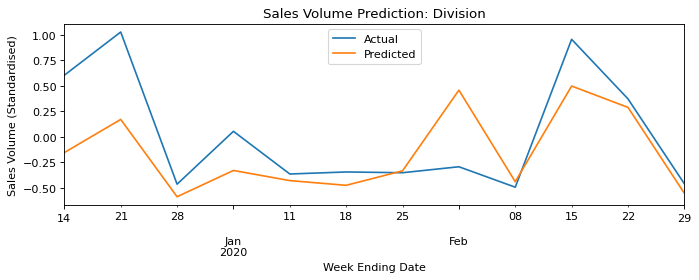

Division: B


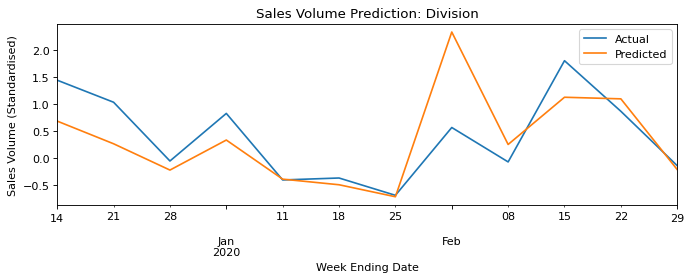

Division: C


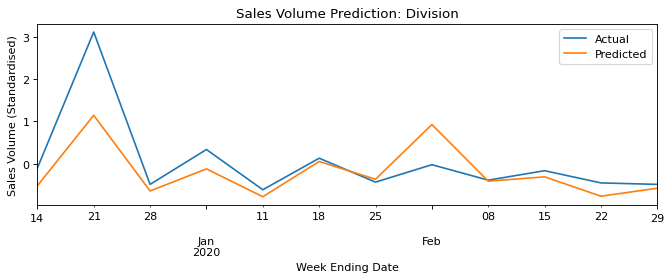

Division: D


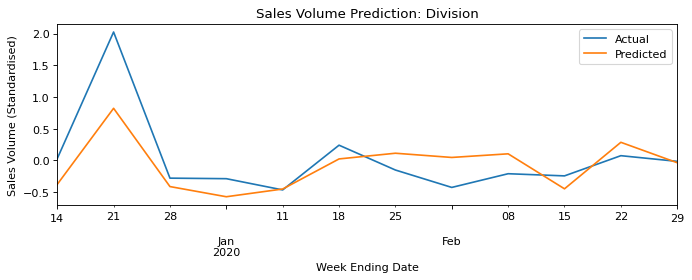

Division: E


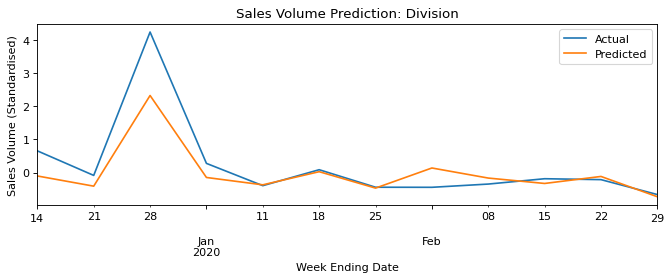

Division: F


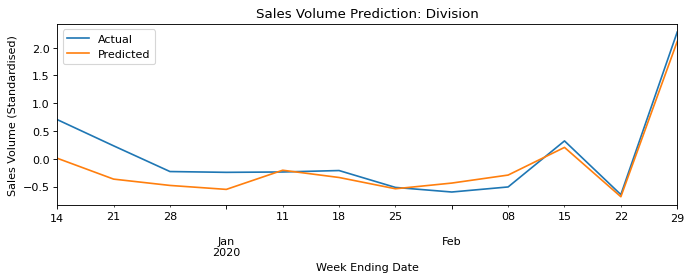

Division: G


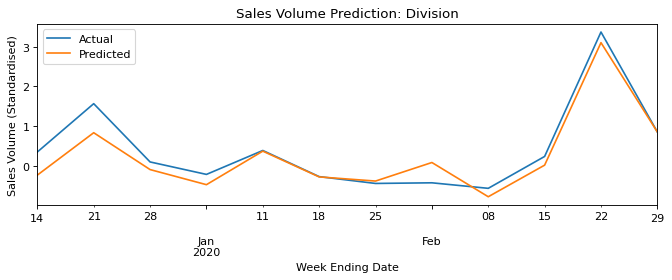

Division: H


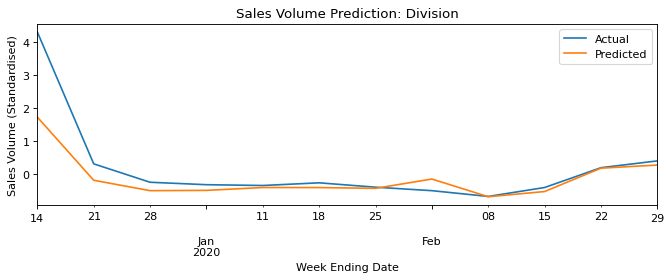

Division: I


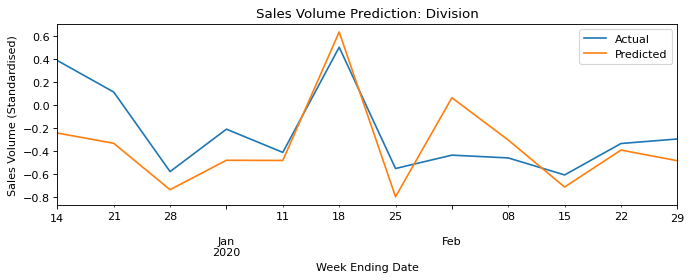

Division: J


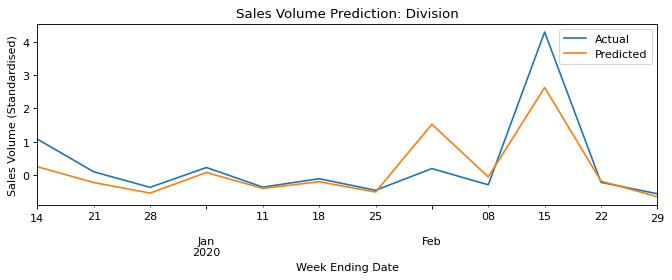

Division: K


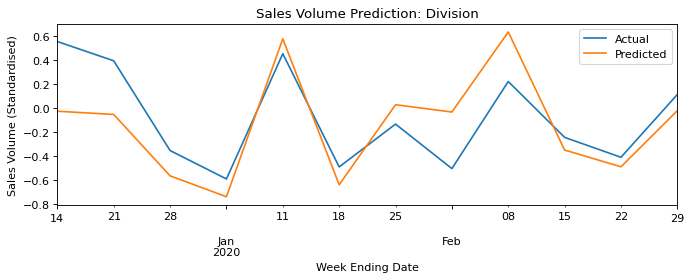

Division: L


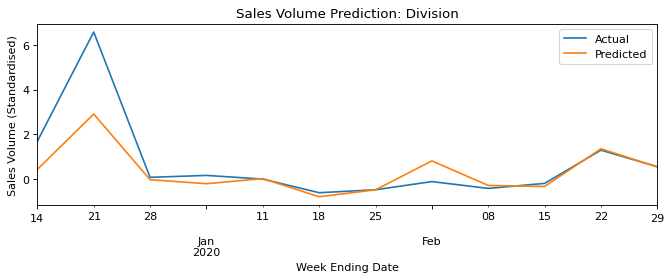

Division: M


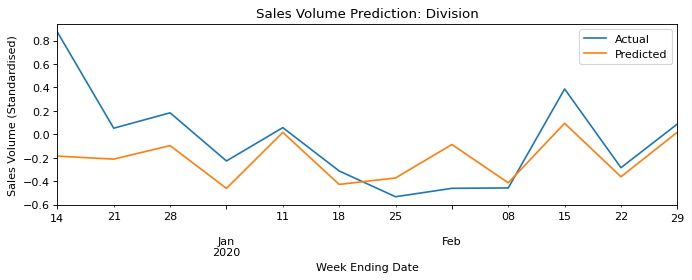

Division: N


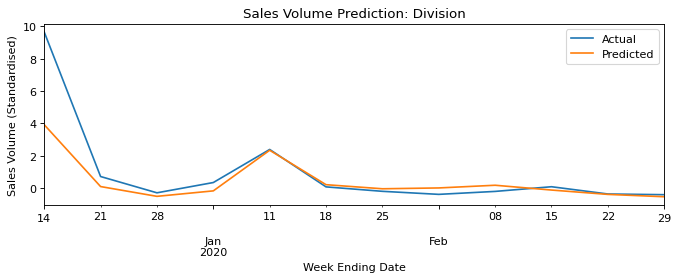

Division: O


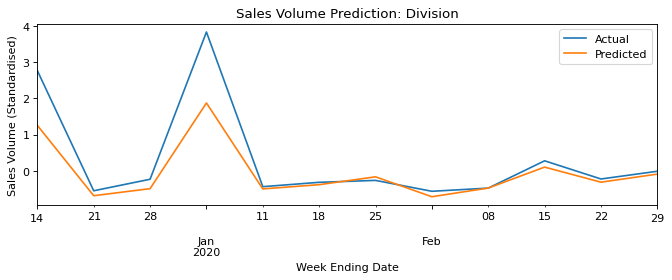

Division: P


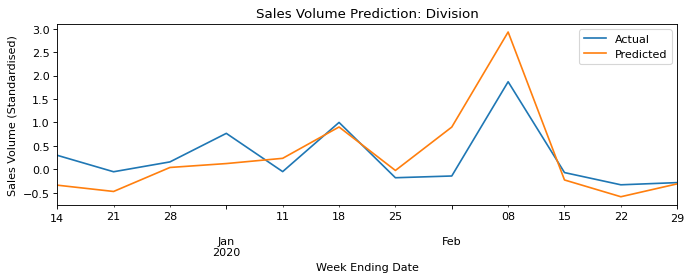

Division: Q


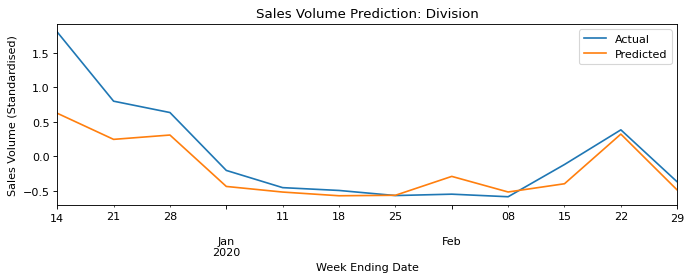

Division: R


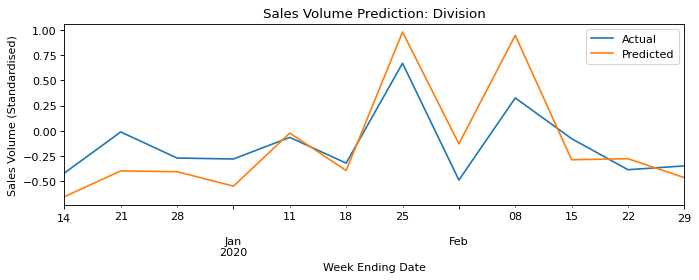

Division: S


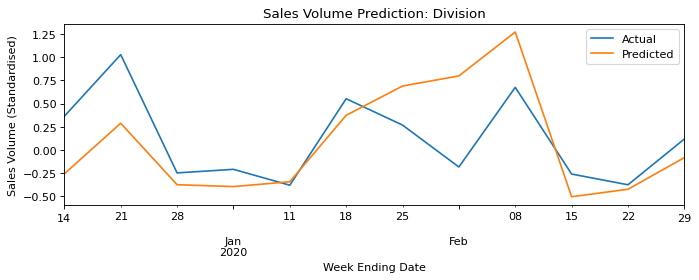

Division: T


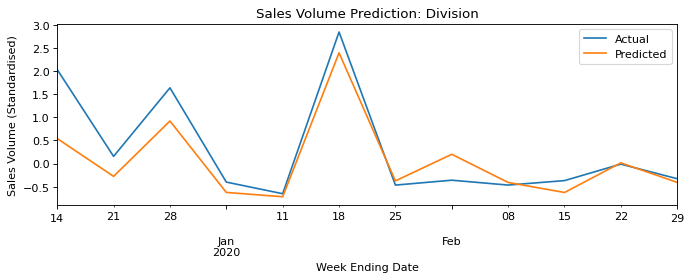

Division: U


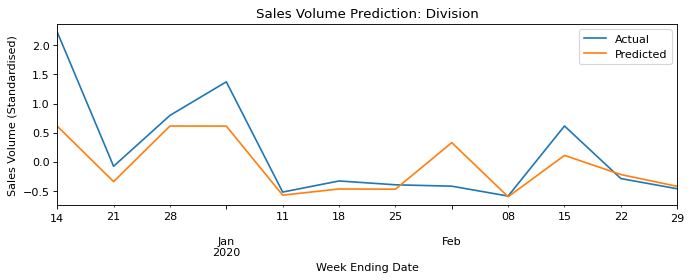

Division: V


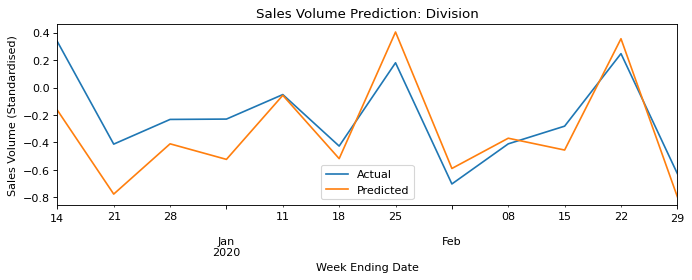

Division: W


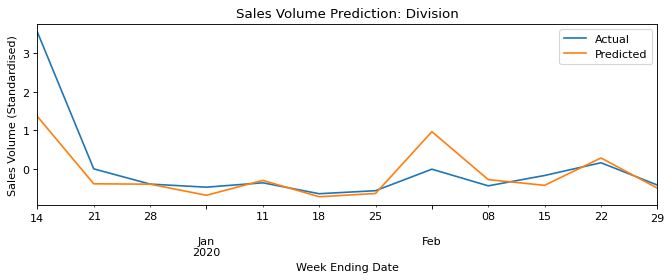

Division: X


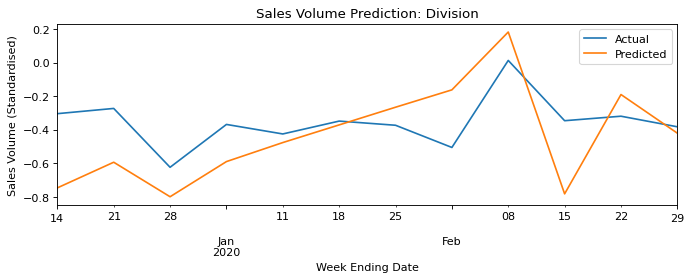

Division: Y


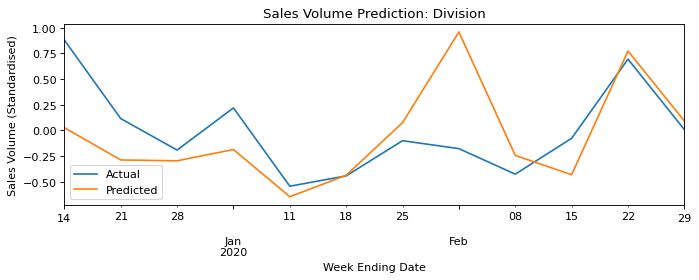

Division: Z


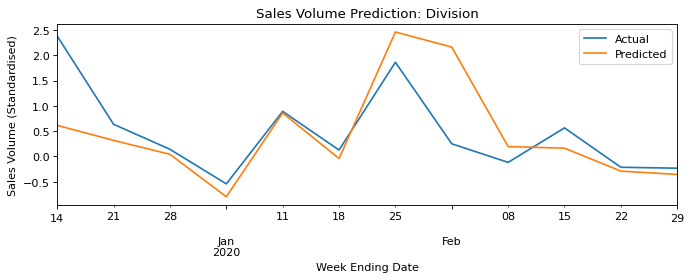

Division: AA


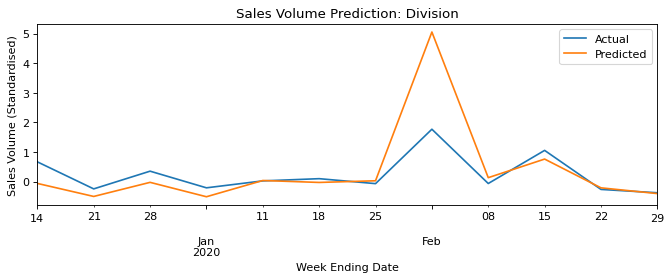

In [28]:
# show test set predictions for each of 27 divisions compared to actual sales volume
divisions = list(string.ascii_uppercase)

divisions.append("AA")

prediction_results = pd.DataFrame(
    {
        "Actual": y_test,
        "Predicted": ols_preds_test,
        "Week": X_test.Calendar_Week,
        "Division": divisions * 12,
    }
)

prediction_results.to_csv("prediction_results.csv")

for division in divisions:
    print("Division:", division)
    prediction_results_division = prediction_results[
        prediction_results["Division"] == division
    ]

    fig = plt.figure(figsize=(10, 3), dpi=80)

    ax = fig.add_subplot(1, 1, 1)

    prediction_results_division.plot(
        x="Week",
        y=["Actual", "Predicted"],
        ax=ax,
        title="Sales Volume Prediction: Division",
        ylabel="Sales Volume (Standardised)",
        xlabel="Week Ending Date",
    )

    plt.show()

In [29]:
# get contributions for whole data using calculated beta coefficients (aggregate contributions quarterly for all divisions)
contributions = media_spends_sales[
    ["Calendar_Week", "Google_Impressions", "Email_Impressions", "Facebook_Impressions"]
]

contributions.set_index("Calendar_Week", inplace=True)

contributions.iloc[:, 0:3] = contributions.iloc[:, 0:3].multiply(
    coefficient_vector, axis=1
)

contributions.insert(0, "(Intercept)", lin_reg_mod.intercept_)

contributions = contributions.resample("Q", convention="end").agg("mean")

contributions.index.rename("Quarter", inplace=True)

contributions

c:\users\gupta\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1754: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, val, pi)


,(Intercept),Google_Impressions,Email_Impressions,Facebook_Impressions
Quarter,,,,
2018-03-31,-0.06291,192.992938,300281.264841,17053.900999
2018-06-30,-0.06291,172456.841188,263021.747518,16104.236687
2018-09-30,-0.06291,328079.619822,233121.400959,57993.939151
2018-12-31,-0.06291,592772.236384,267013.758374,59287.680813
2019-03-31,-0.06291,272335.188058,257388.285508,34204.094928
2019-06-30,-0.06291,304716.953975,209176.237992,42348.218394
2019-09-30,-0.06291,296294.572098,200581.048614,69147.860806
2019-12-31,-0.06291,734095.353057,298813.467072,158828.195585
2020-03-31,-0.06291,277849.414105,276282.740278,56330.686737


<AxesSubplot:title={'center':'Q/Q Channel Impact on Sales Volume'}, xlabel='Quarter of the Year', ylabel='% of total Contribution'>

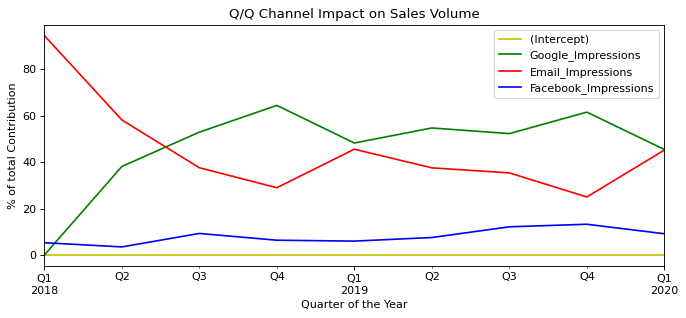

In [30]:
# show Q/Q contribution percentages for considered media channels
chart_data_1 = contributions

chart_data_1.iloc[:, 0:] = (
    chart_data_1.iloc[:, 0:].div(chart_data_1.iloc[:, 0:].sum(1), axis=0).mul(100)
)

fig = plt.figure(figsize=(10, 4), dpi=80)

ax = fig.add_subplot(1, 1, 1)

chart_data_1.plot(
    y=[
        "(Intercept)",
        "Google_Impressions",
        "Email_Impressions",
        "Facebook_Impressions",
    ],
    ax=ax,
    ylabel="% of total Contribution",
    xlabel="Quarter of the Year",
    title="Q/Q Channel Impact on Sales Volume",
    color=["y", "g", "r", "b"],
)

c:\users\gupta\appdata\local\programs\python\python39\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


<AxesSubplot:title={'center':'Actual Total Spend\non Media Channels'}, xlabel='Media Channel', ylabel='Spend'>

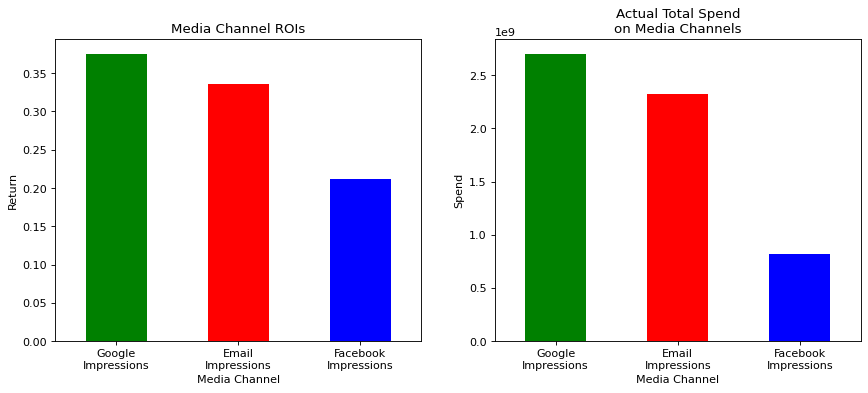

In [31]:
# show model suggested ROIs compared to actual total spends for media channels
chart_data_2 = pd.DataFrame(
    {
        "ROI": list(lin_reg_mod.coef_[:3]),
        "Actual_Spends": media_spends_sales[
            ["Google_Impressions", "Email_Impressions", "Facebook_Impressions"]
        ]
        .agg("sum")
        .to_list(),
    },
    index=["Google\nImpressions", "Email\nImpressions", "Facebook\nImpressions"],
)

fig = plt.figure(figsize=(13, 5), dpi=80)

ax0 = fig.add_subplot(1, 2, 1)

chart_data_2.plot(
    y="ROI",
    ax=ax0,
    legend=False,
    kind="bar",
    ylabel="Return",
    xlabel="Media Channel",
    title="Media Channel ROIs",
    rot=360,
    color=["g", "r", "b"],
)

ax1 = fig.add_subplot(1, 2, 2)

chart_data_2.plot(
    y="Actual_Spends",
    ax=ax1,
    legend=False,
    kind="bar",
    ylabel="Spend",
    xlabel="Media Channel",
    title="Actual Total Spend\non Media Channels",
    rot=360,
    color=["g", "r", "b"],
)

<AxesSubplot:title={'center':'Division ROIs'}, xlabel='Division', ylabel='Return'>

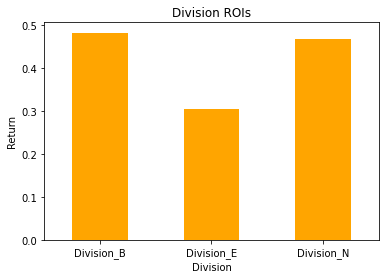

In [32]:
# show returns for considered divisions
chart_data_3 = pd.DataFrame(
    {
        "Division": ["Division_B", "Division_E", "Division_N"],
        "ROI": list(lin_reg_mod.coef_[3:]),
    }
)
chart_data_3.plot(
    x="Division",
    y="ROI",
    legend=False,
    kind="bar",
    ylabel="Return",
    xlabel="Division",
    title="Division ROIs",
    rot=360,
    color=["orange", "orange", "orange"],
)